In [32]:
import os
import re
import torch
import pickle
import pandas as pd
import numpy as np
from itertools import chain
from numpy import linalg as LA
from numpy import dot
from numpy.linalg import norm
from collections import Counter
import sklearn.metrics as metrics
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from scipy import stats as st

In [33]:
The_Dataset_Name = 'LH_ASDNC'

 ## RG-Select scores

In [34]:
def PrintRGResults(rep_dict_name):
    with open(rep_dict_name,'rb') as f: 
        rep_dict = pickle.load(f)
    final_matrix = rep_dict['views average'] + rep_dict['rank correlation']    
    
    repr_scores = (np.sum(final_matrix, axis=0) - 2) / 4
    views_scores = (np.sum(rep_dict['views average'], axis=0) - 1) / 4
    rank_scores = (np.sum(rep_dict['rank correlation'], axis=0) - 1) / 4
    
    model_orders = ['diffpool', 'gat', 'gcn', 'gunet', 'sag']
    
    model_sort_with_repr_scores = np.array(model_orders)[list(reversed(np.argsort(repr_scores)))]
    model_sort_with_rank_scores = np.array(model_orders)[list(reversed(np.argsort(rank_scores)))] 
    model_sort_with_views_scores = np.array(model_orders)[list(reversed(np.argsort(views_scores)))]    
    
    repr_score_dict = {model_sort_with_repr_scores[i]: np.round(np.sort(repr_scores)[::-1][i], 3) for i in range(len(model_orders))}
    rank_score_dict = {model_sort_with_rank_scores[i]: np.round(np.sort(rank_scores)[::-1][i], 3) for i in range(len(model_orders))}
    views_score_dict = {model_sort_with_views_scores[i]: np.round(np.sort(views_scores)[::-1][i], 3) for i in range(len(model_orders))}

    print('REPR SCORE : ', repr_score_dict)
    print('VIEWS SCORE: ', views_score_dict)
    print('RANK SCORE : ', rank_score_dict)
    
    print('REPR MATRIX: '), print(final_matrix)
    print('RANK MATRIX: '), print(rep_dict['rank correlation'].sum(axis=0))    
    print('VIEWS MATRIX: '), print(rep_dict['views average'].sum(axis=0))

In [35]:
PrintRGResults(The_Dataset_Name + '_Ks_15_cv.pickle')

REPR SCORE :  {'diffpool': 0.602, 'gcn': 0.588, 'gat': 0.383, 'gunet': 0.196, 'sag': -0.202}
VIEWS SCORE:  {'gunet': 0.339, 'gcn': 0.331, 'diffpool': 0.331, 'gat': 0.297, 'sag': 0.069}
RANK SCORE :  {'diffpool': 0.271, 'gcn': 0.257, 'gat': 0.086, 'gunet': -0.143, 'sag': -0.271}
REPR MATRIX: 
[[ 2.          1.33015873  0.95396825  0.39365079 -0.26984127]
 [ 1.33015873  2.          0.48730159  0.2015873  -0.48730159]
 [ 0.95396825  0.48730159  2.          0.57460317  0.33492063]
 [ 0.39365079  0.2015873   0.57460317  2.         -0.38571429]
 [-0.26984127 -0.48730159  0.33492063 -0.38571429  2.        ]]
RANK MATRIX: 
[ 2.08571429  1.34285714  2.02857143  0.42857143 -0.08571429]
VIEWS MATRIX: 
[2.32222222 2.18888889 2.32222222 2.35555556 1.27777778]


In [36]:
PrintRGResults(The_Dataset_Name + '_Ks_10_cv.pickle')

REPR SCORE :  {'gcn': 0.453, 'diffpool': 0.267, 'sag': 0.182, 'gunet': 0.176, 'gat': 0.159}
VIEWS SCORE:  {'gunet': 0.204, 'gcn': 0.196, 'diffpool': 0.196, 'gat': 0.188, 'sag': 0.025}
RANK SCORE :  {'gcn': 0.257, 'sag': 0.157, 'diffpool': 0.071, 'gunet': -0.029, 'gat': -0.029}
REPR MATRIX: 
[[ 2.         -0.01428571  0.78333333  0.21428571  0.08571429]
 [-0.01428571  2.          0.00952381 -0.09047619  0.73095238]
 [ 0.78333333  0.00952381  2.          0.84285714  0.17619048]
 [ 0.21428571 -0.09047619  0.84285714  2.         -0.26428571]
 [ 0.08571429  0.73095238  0.17619048 -0.26428571  2.        ]]
RANK MATRIX: 
[1.28571429 0.88571429 2.02857143 0.88571429 1.62857143]
VIEWS MATRIX: 
[1.78333333 1.75       1.78333333 1.81666667 1.1       ]


In [37]:
PrintRGResults(The_Dataset_Name + '_Ks_5_cv.pickle')

REPR SCORE :  {'gcn': 0.087, 'sag': 0.082, 'diffpool': 0.069, 'gat': -0.119, 'gunet': -0.169}
VIEWS SCORE:  {'gunet': 0.117, 'diffpool': 0.083, 'gat': 0.067, 'gcn': 0.058, 'sag': 0.025}
RANK SCORE :  {'sag': 0.057, 'gcn': 0.029, 'diffpool': -0.014, 'gat': -0.186, 'gunet': -0.286}
REPR MATRIX: 
[[ 2.         -0.2047619  -0.2         0.70952381 -0.02857143]
 [-0.2047619   2.          0.4047619  -0.87619048  0.2       ]
 [-0.2         0.4047619   2.         -0.26190476  0.4047619 ]
 [ 0.70952381 -0.87619048 -0.26190476  2.         -0.24761905]
 [-0.02857143  0.2         0.4047619  -0.24761905  2.        ]]
RANK MATRIX: 
[ 0.94285714  0.25714286  1.11428571 -0.14285714  1.22857143]
VIEWS MATRIX: 
[1.33333333 1.26666667 1.23333333 1.46666667 1.1       ]


## Our Methodology

In [38]:
def GetBiomarkers(model, weights):
    weights_vector = None

    if model == 'sag':
        weights_vector = torch.mean(weights['w'], 0).detach().cpu().numpy() 
    elif model == 'diffpool':
        weights_vector = torch.mean(weights['w'], 1).detach().numpy()
    elif model == 'gcn':
        weights_vector = weights['w'].squeeze().detach().numpy()
        #weights_vector = torch.mean(weights['w'], 1).detach().numpy()
    elif model == 'gat':
        weights_vector = weights['w'].squeeze().detach().numpy()
    elif model == 'gunet':
        weights_vector = torch.mean(weights['w'], 0).detach().numpy()  
    else:
        exit()
            
    return weights_vector

In [39]:
def GetModelDf(model_name):
    df = pd.DataFrame(columns=['model', 'dataset_type', 'dataset', 'view', 'cv_no', 'weights', 'labels', 'preds'])
    subdir_names = os.listdir(model_name)
    for subdir in subdir_names:
        if subdir == 'Labels_and_preds':
            file_names = os.listdir(os.path.join(model_name, subdir))
            for file in file_names:
                if 'test' not in file:
                    pred_label_path = os.path.join(model_name, subdir, file)
                    with open(pred_label_path, 'rb') as f:
                        pred_label_file = pickle.load(f)
                    with open(pred_label_path.replace('train', 'test'), 'rb') as f:
                        test_pred_label_file = pickle.load(f)

                        
                    weight_path = pred_label_path.replace('MainModel', 'W_MainModel').replace('Labels_and_preds', 'weights').replace('_train.pickle', '.pickle')
                    #print('weight_path: ', weight_path)

                    with open(weight_path, 'rb') as f:
                        weight_file = pickle.load(f)

                    cv_no = str(re.findall("CV_.", pred_label_path))[5]
                    view_no = str(re.findall("view_.", pred_label_path))[7]
                    #dataset_no = str(re.findall("_d._", pred_label_path))[4]

                    #print('cv: ', cv_no, 'view: ', view_no, 'dataset: ', dataset_no)
                    new_row = {
                               'model': model_name,
                               'dataset_type': The_Dataset_Name, 
                               #'dataset': dataset_no, 
                               'view': view_no, 
                               'cv_no': cv_no, 
                               'weights': GetBiomarkers(model_name, weight_file), 
                               'train_labels': pred_label_file['labels'], 
                               'train_preds': pred_label_file['preds'],
                               'test_labels': test_pred_label_file['labels'], 
                               'test_preds': test_pred_label_file['preds'],
                                }

                    df = pd.concat([df, pd.DataFrame.from_records([new_row])], ignore_index=True)
                    #df = pd.concat([df, pd.DataFrame.from_records([{ 'a': 1, 'b': 2 }])])
                    #print(opened_file_path, model, cv_no, view_no, dataset_no)
                    
                    df['w'] = df['weights'].map(lambda x: np.abs(x))
                    all_biomarkers = list(chain.from_iterable(df['w'].map(lambda x: x).to_numpy()))
                    min_val, max_val = min(all_biomarkers), max(all_biomarkers)
                    df['n'] = df['w'].map(lambda x: (x - min_val) / (max_val - min_val))  

    return df

In [40]:
def GetDatasetsByView(df):
    df_dataset0 = df[df['view'] == '0']
    df_dataset1 = df[df['view'] == '1']
    df_dataset2 = df[df['view'] == '2']
    df_dataset3 = df[df['view'] == '3']
    df_dataset4 = df[df['view'] == '4']
    df_dataset5 = df[df['view'] == '5']
    
    df_dataset0 = df_dataset0.sort_values(by=['cv_no'])
    df_dataset1 = df_dataset1.sort_values(by=['cv_no'])
    df_dataset2 = df_dataset2.sort_values(by=['cv_no'])
    df_dataset3 = df_dataset3.sort_values(by=['cv_no'])
    df_dataset4 = df_dataset4.sort_values(by=['cv_no'])
    df_dataset5 = df_dataset5.sort_values(by=['cv_no'])
    
    return [df_dataset0, df_dataset1, df_dataset2, df_dataset3, df_dataset4, df_dataset5]

In [41]:
df_gcn = GetModelDf("gcn")
gcn_datasets = GetDatasetsByView(df_gcn)
df_gcn#.sort_values(by=['cv_no'])

,model,dataset_type,dataset,view,cv_no,weights,labels,preds,train_labels,train_preds,test_labels,test_preds,w,n
0,gcn,LH_ASDNC,NaN,2,3,"[0.16066833, 0.13505433, 0.15165433, -0.060330...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0.16066833, 0.13505433, 0.15165433, 0.0603303...","[0.838708, 0.704667, 0.7915367, 0.3136275, 0.3..."
1,gcn,LH_ASDNC,NaN,0,3,"[0.15732002, 0.13605203, 0.1512491, -0.0636897...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, ...","[0.15732002, 0.13605203, 0.1512491, 0.06368978...","[0.82118595, 0.70988804, 0.7894161, 0.3312079,..."
2,gcn,LH_ASDNC,NaN,5,2,"[0.15922722, 0.15374441, 0.17657454, -0.061664...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, ...","[0.15922722, 0.15374441, 0.17657454, 0.0616645...","[0.8311665, 0.8024744, 0.9219471, 0.32060942, ..."
3,gcn,LH_ASDNC,NaN,4,2,"[0.16292083, 0.13645568, 0.144762, -0.05808449...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, ...","[0.16292083, 0.13645568, 0.144762, 0.058084495...","[0.85049564, 0.7120004, 0.7554683, 0.30187476,..."
4,gcn,LH_ASDNC,NaN,1,1,"[0.16302794, 0.13638008, 0.14201143, -0.057977...",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.16302794, 0.13638008, 0.14201143, 0.0579771...","[0.85105616, 0.7116047, 0.74107426, 0.30131298..."
5,gcn,LH_ASDNC,NaN,3,3,"[0.16094077, 0.13922432, 0.14928113, -0.059993...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.16094077, 0.13922432, 0.14928113, 0.0599935...","[0.8401337, 0.726489, 0.77911747, 0.3118649, 0..."
6,gcn,LH_ASDNC,NaN,3,1,"[0.16348527, 0.13709262, 0.14959766, -0.057465...",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.16348527, 0.13709262, 0.14959766, 0.0574652...","[0.8534494, 0.7153336, 0.7807739, 0.298634, 0...."
7,gcn,LH_ASDNC,NaN,0,2,"[0.15837951, 0.13525918, 0.15121678, -0.062630...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, ...","[0.15837951, 0.13525918, 0.15121678, 0.0626301...","[0.8267304, 0.70573896, 0.7892469, 0.32566294,..."
8,gcn,LH_ASDNC,NaN,1,3,"[0.16344443, 0.13798764, 0.14870547, -0.057564...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, ...","[0.16344443, 0.13798764, 0.14870547, 0.0575646...","[0.85323566, 0.7200173, 0.7761049, 0.2991544, ..."
9,gcn,LH_ASDNC,NaN,5,3,"[0.16864496, 0.16324726, 0.1731666, -0.0521947...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0.16864496, 0.16324726, 0.1731666, 0.052

In [42]:
df_diffpool = GetModelDf("diffpool")
diffpool_datasets = GetDatasetsByView(df_diffpool)
df_diffpool#.sort_values(by=['cv_no'])

,model,dataset_type,dataset,view,cv_no,weights,labels,preds,train_labels,train_preds,test_labels,test_preds,w,n
0,diffpool,LH_ASDNC,NaN,2,4,"[-0.0029166692, -0.0062247044, 0.0037626843, 0...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, ...","[0.0029166692, 0.0062247044, 0.0037626843, 0.0...","[0.13565315, 0.2898861, 0.17509753, 0.20213477..."
1,diffpool,LH_ASDNC,NaN,2,0,"[-0.005145098, -0.0068195397, 0.0011850551, 0....",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.005145098, 0.0068195397, 0.0011850551, 0.00...","[0.23955081, 0.31761953, 0.05491884, 0.1272695..."
2,diffpool,LH_ASDNC,NaN,0,1,"[-0.0060435925, -0.008809334, 0.0016019796, 0....",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0.0060435925, 0.008809334, 0.0016019796, 0.00...","[0.281442, 0.41039118, 0.07435742, 0.11634573,..."
3,diffpool,LH_ASDNC,NaN,1,4,"[-0.0063220286, -0.008333623, -0.000533672, 0....",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ...","[0.0063220286, 0.008333623, 0.000533672, 0.001...","[0.2944237, 0.3882118, 0.024548933, 0.06429927..."
4,diffpool,LH_ASDNC,NaN,4,3,"[-0.0020681017, -0.008586129, 0.0029449721, 0....",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...","[0.0020681017, 0.008586129, 0.0029449721, 0.00...","[0.096089765, 0.39998454, 0.13697274, 0.111257..."
5,diffpool,LH_ASDNC,NaN,2,2,"[-0.003797527, -0.0057990015, 0.0026738192, 0....",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[0.003797527, 0.0057990015, 0.0026738192, 0.00...","[0.17672202, 0.27003825, 0.12433058, 0.1606735..."
6,diffpool,LH_ASDNC,NaN,5,2,"[-0.00041077472, -0.0038210708, 0.005822016, 0...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.00041077472, 0.0038210708, 0.005822016, 0.0...","[0.018819004, 0.17781973, 0.27111125, 0.356099..."
7,diffpool,LH_ASDNC,NaN,3,4,"[-0.005519814, -0.00743053, 0.0023314713, 0.00...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[0.005519814, 0.00743053, 0.0023314713, 0.0027...","[0.25702146, 0.3461062, 0.108369045, 0.1257673..."
8,diffpool,LH_ASDNC,NaN,1,1,"[-0.004585604, -0.007636104, 5.4586446e-05, 0....",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...","[0.004585604, 0.007636104, 5.4586446e-05, 0.00...","[0.21346512, 0.3556908, 0.0022121773, 0.136847..."
9,diffpool,LH_ASDNC,NaN,4,2,"[0.0009810537, -0.0028527197, 0.004825263, 0.0...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 

In [43]:
df_gunet = GetModelDf("gunet")
gunet_datasets = GetDatasetsByView(df_gunet)
df_gunet#.head()

,model,dataset_type,dataset,view,cv_no,weights,labels,preds,train_labels,train_preds,test_labels,test_preds,w,n
0,gunet,LH_ASDNC,NaN,5,1,"[0.7936466, -0.576373, -0.7680454, -0.87525296...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.7936466, 0.576373, 0.7680454, 0.87525296, 2...","[0.2532239, 0.18357389, 0.2450171, 0.27938393,..."
1,gunet,LH_ASDNC,NaN,5,0,"[-0.3839899, -0.76080054, -2.6513946, -0.59395...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, ...","[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.3839899, 0.76080054, 2.6513946, 0.5939501, ...","[0.12190287, 0.24269466, 0.84875035, 0.1892084..."
2,gunet,LH_ASDNC,NaN,1,1,"[-0.8047803, -0.15785794, -1.2666754, -1.63858...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.8047803, 0.15785794, 1.2666754, 1.6385876, ...","[0.25679296, 0.049413193, 0.4048597, 0.5240812..."
3,gunet,LH_ASDNC,NaN,1,4,"[-0.85870034, 0.7786339, -0.54228014, -0.81213...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.85870034, 0.7786339, 0.54228014, 0.8121369,...","[0.27407777, 0.24841139, 0.17264497, 0.2591512..."
4,gunet,LH_ASDNC,NaN,3,1,"[-2.0228937, -1.5795254, -0.066711344, -1.7795...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2.0228937, 1.5795254, 0.066711344, 1.7795426,...","[0.6472758, 0.505148, 0.020194909, 0.56926626,..."
5,gunet,LH_ASDNC,NaN,1,3,"[-0.88142085, 0.060984373, -0.38065705, -0.808...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.88142085, 0.060984373, 0.38065705, 0.808803...","[0.28136113, 0.018359052, 0.12083448, 0.258082..."
6,gunet,LH_ASDNC,NaN,4,1,"[-0.6182384, 0.31137642, 0.087907195, -0.73404...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.6182384, 0.31137642, 0.087907195, 0.7340436...","[0.19699442, 0.09862563, 0.026989527, 0.234117..."
7,gunet,LH_ASDNC,NaN,5,4,"[-2.271541, 0.0037132103, -0.4133792, -0.94544...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2.271541, 0.0037132103, 0.4133792, 0.945443, ...","[0.72698313, 0.0, 0.13132401, 0.3018843, 0.227..."
8,gunet,LH_ASDNC,NaN,5,2,"[-0.12964441, -0.096764006, -0.100969315, -0.1...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0.12964441, 0.096764006, 0.100969315, 0.13016...","[0.040368963, 0.029828697, 0.031176768, 0.0405..."
9,gunet,LH_ASDNC,NaN,2,3,"[0.85134214, -0.8951563, -0.9114397, -0.653786...",NaN,NaN,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.85134214, 0.895156

In [44]:
df_gat = GetModelDf("gat")
gat_datasets = GetDatasetsByView(df_gat)
df_gat#.head()

,model,dataset_type,dataset,view,cv_no,weights,labels,preds,train_labels,train_preds,test_labels,test_preds,w,n
0,gat,LH_ASDNC,NaN,1,2,"[0.023063622, 0.069272585, -0.048519336, 0.038...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.023063622, 0.069272585, 0.048519336, 0.0380...","[0.16870715, 0.50685394, 0.3549863, 0.27826822..."
1,gat,LH_ASDNC,NaN,2,2,"[-0.108309016, 0.00027426274, -0.02464876, -0....",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.108309016, 0.00027426274, 0.02464876, 0.007...","[0.7925137, 0.0019397533, 0.18030682, 0.054347..."
2,gat,LH_ASDNC,NaN,0,2,"[-0.051672842, -0.009522428, -0.055882152, -0....",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.051672842, 0.009522428, 0.055882152, 0.0205...","[0.37806293, 0.06961574, 0.40886572, 0.1501554..."
3,gat,LH_ASDNC,NaN,0,4,"[0.03156741, 0.02219344, -0.010648272, 0.00766...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.03156741, 0.02219344, 0.010648272, 0.007668...","[0.23093593, 0.16233934, 0.07785441, 0.0560454..."
4,gat,LH_ASDNC,NaN,0,1,"[0.0017266019, -0.039406057, -0.047196496, -0....",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0017266019, 0.039406057, 0.047196496, 0.008...","[0.012567643, 0.28829738, 0.34530607, 0.063048..."
5,gat,LH_ASDNC,NaN,0,3,"[0.042616848, -0.0037744057, -0.012649039, 0.0...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.042616848, 0.0037744057, 0.012649039, 0.000...","[0.3117932, 0.02755301, 0.092495576, 0.0071186..."
6,gat,LH_ASDNC,NaN,3,4,"[-0.005307767, 0.0027488156, 0.0034871516, -0....",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.005307767, 0.0027488156, 0.0034871516, 0.01...","[0.0387738, 0.020047974, 0.025450949, 0.142872..."
7,gat,LH_ASDNC,NaN,3,1,"[-0.050600514, 0.0061190575, 0.01297032, -0.00...",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.050600514, 0.0061190575, 0.01297032, 0.0088...","[0.3702159, 0.044710644, 0.094846636, 0.064457..."
8,gat,LH_ASDNC,NaN,1,1,"[0.023131752, -0.004338759, -0.022537038, 0.05...",NaN,NaN,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0.023131752, 0.004338759, 0.022537038, 0.0523...","[0.16920571, 0.03168282, 0.16485372, 0.3831763..."
9,gat,LH_ASDNC,NaN,5,2,"[-0.017749099, 0.014494464, 0.0029230614, 0.04...",NaN,NaN,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, ...","[0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0.017749099, 0.014494464, 0.0029230614, 

In [45]:
df_sag = GetModelDf("sag")
sag_datasets = GetDatasetsByView(df_sag)
df_sag#.head()

,model,dataset_type,dataset,view,cv_no,weights,labels,preds,train_labels,train_preds,test_labels,test_preds,w,n
0,sag,LH_ASDNC,NaN,2,1,"[-2.4355013e-14, -7.9422874e-15, -7.03134e-15,...",NaN,NaN,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, ...","[0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[2.4355013e-14, 7.9422874e-15, 7.03134e-15, 2....","[1.0068504e-12, 3.2833878e-13, 2.9067967e-13, ..."
1,sag,LH_ASDNC,NaN,2,4,"[0.00022351817, 4.2670813e-06, 3.4483182e-07, ...",NaN,NaN,"[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.00022351817, 4.2670813e-06, 3.4483182e-07, ...","[0.009240371, 0.00017640363, 1.4255548e-05, 0...."
2,sag,LH_ASDNC,NaN,1,4,"[0.008354922, 0.0090138875, 0.00655974, 0.0081...",NaN,NaN,"[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.008354922, 0.0090138875, 0.00655974, 0.0081...","[0.34539732, 0.37263936, 0.27118346, 0.3379581..."
3,sag,LH_ASDNC,NaN,0,0,"[3.4208396e-12, 2.596752e-12, -7.1247565e-12, ...",NaN,NaN,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","[3.4208396e-12, 2.596752e-12, 7.1247565e-12, 3...","[1.414195e-10, 1.0735124e-10, 2.9454159e-10, 1..."
4,sag,LH_ASDNC,NaN,3,4,"[0.0005361984, 1.1695011e-05, 2.8312315e-06, 0...",NaN,NaN,"[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0005361984, 1.1695011e-05, 2.8312315e-06, 0...","[0.022166753, 0.00048347857, 0.00011704476, 0...."
5,sag,LH_ASDNC,NaN,3,1,"[2.4601245e-06, 6.863402e-07, 8.4290446e-07, 2...",NaN,NaN,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[2.4601245e-06, 6.863402e-07, 8.4290446e-07, 2...","[0.00010170298, 2.8373703e-05, 3.484616e-05, 0..."
6,sag,LH_ASDNC,NaN,1,1,"[8.181603e-05, 3.8962575e-05, 1.4325404e-05, 2...",NaN,NaN,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, ...","[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...","[8.181603e-05, 3.8962575e-05, 1.4325404e-05, 2...","[0.0033823224, 0.0016107355, 0.0005922205, 0.0..."
7,sag,LH_ASDNC,NaN,1,3,"[0.017023996, 0.013855415, 0.009946956, 0.0160...",NaN,NaN,"[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, ...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0.017023996, 0.013855415, 0.009946956, 0.0160...","[0.7037819, 0.5727909, 0.41121295, 0.6641522, ..."
8,sag,LH_ASDNC,NaN,2,3,"[7.05444e-40, 5.20053e-40, 7.2889e-40, -8.5193...",NaN,NaN,"[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...","[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...","[7.05444e-40, 5.20053e-40, 7.2889e-40, 8.51939...","[2.8818392e-38, 2.115419e-38, 2.9787628e-38, 3..."
9,sag,LH_ASDNC,NaN,2,0,"[-1.0404896e-17, -1.9620575e-17, -1.2769403e-1...",NaN,NaN,"[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1.0404896e-17, 1.9620575e-17, 1.2769403e

In [46]:
# 0. biomarker en küçük 8. biomarker demek degil! (bana bu lazim) : argsort argsort
# 8. biomarker en küçük biomarker demek! (bu[argsort] lazim degil)
llm = [0.16110869, 0.14068228, 0.1535641,  0.05990085, 0.05777565, 0.01962589,
 0.05002575, 0.0685641,  0.01497542, 0.10926928, 0.12729558, 0.16272868,
 0.04551447, 0.02275075, 0.10391028, 0.08341169, 0.03719392, 0.07100126,
 0.06683969, 0.06206064, 0.13141218, 0.08685517, 0.126066,   0.02624511,
 0.16088009, 0.0366286,  0.02318038, 0.02092858, 0.10593221, 0.08378284,
 0.11462475, 0.03707968, 0.01594063, 0.02346183, 0.10462112]
# print(np.argsort(llm)) : EN KUCUK BIOMARKER 8. BIOMARKER
# burada bir indiste bulunan biomarkerları karsilastirirken 8. bio ve 6. bio karsilastiriliyor: sacma
# [ 8 32  5 27 13 26 33 23 25 31 16 12  6  4  3 19 18  7 17 15 29 21 14 34
# 28  9 30 22 10 20  1  2 24  0 11]
# print(np.argsort(np.argsort(llm))) # 8. BIOMARKER EN KUCUK BIOMARKER
# burada ise 8. biomarkerin kacinci kucuk biomarker oldugu karsilastiriliyor: mantikli
# [33 30 31 14 13  2 12 17  0 25 28 34 11  4 22 19 10 18 16 15 29 21 27  7
# 32  8  5  3 24 20 26  9  1  6 23]


In [47]:
def PrintScores(datasets):
    for dset_no, df_dset in enumerate(datasets):
        for i in range(5):
            train_labels, train_preds = df_dset['train_labels'].iloc[i], df_dset['train_preds'].iloc[i]
            test_labels, test_preds = df_dset['test_labels'].iloc[i], df_dset['test_preds'].iloc[i]

            f1_train = metrics.accuracy_score(train_labels, train_preds)
            f1_test = metrics.accuracy_score(test_labels, test_preds)
            #print('cv', i, ' ', f1, f2, f3)
            print(f"view {dset_no} cv {i} train {np.round(f1_train, 2)} test {np.round(f1_test, 2)}")
        print()

In [48]:
PrintScores(gcn_datasets)

view 0 cv 0 train 0.61 test 0.63
view 0 cv 1 train 0.57 test 0.55
view 0 cv 2 train 0.52 test 0.62
view 0 cv 3 train 0.53 test 0.53
view 0 cv 4 train 0.55 test 0.45

view 1 cv 0 train 0.78 test 0.68
view 1 cv 1 train 0.56 test 0.65
view 1 cv 2 train 0.68 test 0.62
view 1 cv 3 train 0.49 test 0.58
view 1 cv 4 train 0.53 test 0.45

view 2 cv 0 train 0.52 test 0.53
view 2 cv 1 train 0.58 test 0.58
view 2 cv 2 train 0.52 test 0.58
view 2 cv 3 train 0.56 test 0.47
view 2 cv 4 train 0.52 test 0.53

view 3 cv 0 train 0.46 test 0.5
view 3 cv 1 train 0.48 test 0.52
view 3 cv 2 train 0.49 test 0.55
view 3 cv 3 train 0.48 test 0.53
view 3 cv 4 train 0.5 test 0.48

view 4 cv 0 train 0.61 test 0.67
view 4 cv 1 train 0.77 test 0.67
view 4 cv 2 train 0.58 test 0.53
view 4 cv 3 train 0.56 test 0.6
view 4 cv 4 train 0.7 test 0.62

view 5 cv 0 train 0.55 test 0.58
view 5 cv 1 train 0.45 test 0.6
view 5 cv 2 train 0.71 test 0.55
view 5 cv 3 train 0.78 test 0.57
view 5 cv 4 train 0.49 test 0.55



In [49]:
PrintScores(diffpool_datasets)

view 0 cv 0 train 0.48 test 0.5
view 0 cv 1 train 0.89 test 0.53
view 0 cv 2 train 0.96 test 0.62
view 0 cv 3 train 0.88 test 0.47
view 0 cv 4 train 0.95 test 0.67

view 1 cv 0 train 0.48 test 0.55
view 1 cv 1 train 0.96 test 0.55
view 1 cv 2 train 0.98 test 0.62
view 1 cv 3 train 0.98 test 0.5
view 1 cv 4 train 1.0 test 0.42

view 2 cv 0 train 0.54 test 0.52
view 2 cv 1 train 0.95 test 0.43
view 2 cv 2 train 0.73 test 0.65
view 2 cv 3 train 0.87 test 0.58
view 2 cv 4 train 0.94 test 0.53

view 3 cv 0 train 0.58 test 0.55
view 3 cv 1 train 1.0 test 0.7
view 3 cv 2 train 0.97 test 0.48
view 3 cv 3 train 0.95 test 0.5
view 3 cv 4 train 1.0 test 0.75

view 4 cv 0 train 0.68 test 0.67
view 4 cv 1 train 1.0 test 0.47
view 4 cv 2 train 0.99 test 0.5
view 4 cv 3 train 0.98 test 0.52
view 4 cv 4 train 1.0 test 0.6

view 5 cv 0 train 0.57 test 0.55
view 5 cv 1 train 1.0 test 0.57
view 5 cv 2 train 0.97 test 0.48
view 5 cv 3 train 1.0 test 0.57
view 5 cv 4 train 0.99 test 0.58



In [50]:
PrintScores(gunet_datasets)

view 0 cv 0 train 0.52 test 0.5
view 0 cv 1 train 0.41 test 0.5
view 0 cv 2 train 0.49 test 0.5
view 0 cv 3 train 0.49 test 0.5
view 0 cv 4 train 0.51 test 0.5

view 1 cv 0 train 0.49 test 0.5
view 1 cv 1 train 0.49 test 0.5
view 1 cv 2 train 0.49 test 0.5
view 1 cv 3 train 0.52 test 0.5
view 1 cv 4 train 0.43 test 0.5

view 2 cv 0 train 0.49 test 0.5
view 2 cv 1 train 0.49 test 0.5
view 2 cv 2 train 0.54 test 0.5
view 2 cv 3 train 0.5 test 0.5
view 2 cv 4 train 0.5 test 0.5

view 3 cv 0 train 0.52 test 0.5
view 3 cv 1 train 0.53 test 0.5
view 3 cv 2 train 0.48 test 0.5
view 3 cv 3 train 0.46 test 0.5
view 3 cv 4 train 0.49 test 0.55

view 4 cv 0 train 0.51 test 0.52
view 4 cv 1 train 0.54 test 0.5
view 4 cv 2 train 0.5 test 0.5
view 4 cv 3 train 0.52 test 0.52
view 4 cv 4 train 0.47 test 0.5

view 5 cv 0 train 0.56 test 0.5
view 5 cv 1 train 0.48 test 0.5
view 5 cv 2 train 0.51 test 0.58
view 5 cv 3 train 0.49 test 0.5
view 5 cv 4 train 0.5 test 0.5



In [51]:
PrintScores(gat_datasets)

view 0 cv 0 train 0.53 test 0.57
view 0 cv 1 train 0.53 test 0.5
view 0 cv 2 train 0.45 test 0.53
view 0 cv 3 train 0.48 test 0.5
view 0 cv 4 train 0.43 test 0.52

view 1 cv 0 train 0.46 test 0.52
view 1 cv 1 train 0.5 test 0.53
view 1 cv 2 train 0.45 test 0.52
view 1 cv 3 train 0.5 test 0.58
view 1 cv 4 train 0.53 test 0.68

view 2 cv 0 train 0.5 test 0.52
view 2 cv 1 train 0.53 test 0.5
view 2 cv 2 train 0.52 test 0.52
view 2 cv 3 train 0.51 test 0.58
view 2 cv 4 train 0.53 test 0.5

view 3 cv 0 train 0.45 test 0.5
view 3 cv 1 train 0.48 test 0.5
view 3 cv 2 train 0.52 test 0.52
view 3 cv 3 train 0.49 test 0.52
view 3 cv 4 train 0.48 test 0.53

view 4 cv 0 train 0.51 test 0.53
view 4 cv 1 train 0.42 test 0.5
view 4 cv 2 train 0.52 test 0.55
view 4 cv 3 train 0.55 test 0.53
view 4 cv 4 train 0.5 test 0.52

view 5 cv 0 train 0.49 test 0.6
view 5 cv 1 train 0.55 test 0.5
view 5 cv 2 train 0.49 test 0.53
view 5 cv 3 train 0.53 test 0.5
view 5 cv 4 train 0.54 test 0.52



In [52]:
PrintScores(sag_datasets)

view 0 cv 0 train 0.65 test 0.47
view 0 cv 1 train 0.76 test 0.62
view 0 cv 2 train 0.68 test 0.58
view 0 cv 3 train 0.66 test 0.5
view 0 cv 4 train 0.5 test 0.5

view 1 cv 0 train 0.7 test 0.48
view 1 cv 1 train 0.66 test 0.53
view 1 cv 2 train 0.66 test 0.55
view 1 cv 3 train 0.47 test 0.62
view 1 cv 4 train 0.5 test 0.5

view 2 cv 0 train 0.63 test 0.52
view 2 cv 1 train 0.63 test 0.53
view 2 cv 2 train 0.64 test 0.6
view 2 cv 3 train 0.69 test 0.5
view 2 cv 4 train 0.5 test 0.5

view 3 cv 0 train 0.66 test 0.43
view 3 cv 1 train 0.66 test 0.53
view 3 cv 2 train 0.68 test 0.6
view 3 cv 3 train 0.71 test 0.55
view 3 cv 4 train 0.5 test 0.5

view 4 cv 0 train 0.62 test 0.48
view 4 cv 1 train 0.67 test 0.52
view 4 cv 2 train 0.68 test 0.55
view 4 cv 3 train 0.67 test 0.45
view 4 cv 4 train 0.5 test 0.5

view 5 cv 0 train 0.61 test 0.5
view 5 cv 1 train 0.7 test 0.52
view 5 cv 2 train 0.7 test 0.53
view 5 cv 3 train 0.67 test 0.5
view 5 cv 4 train 0.5 test 0.5



In [96]:
def CalculateReprScore(df_datasets):
    def Calculate_mIv(current_df):
        m_M_v = np.asarray(list(current_df['n'].map(lambda x: x).to_numpy())).T
        m_I_v = np.array([LA.norm(nth_bios) for nth_bios in m_M_v])
        return m_I_v
    
    def CalculateMd(m_I_v_s):
        m_d = None
        d_list = []
        for i in range(len(m_I_v_s)):
            for k in range(i+1, len(m_I_v_s)):
                d_ik = LA.norm(m_I_v_s[i] - m_I_v_s[k]) ** 2
                d_list.append(d_ik)

        m_d = np.array(d_list)
        return m_d

    def FindTopIndices_with_L2AcrossViewsFolds(df_datasets):
        all_datasets = np.asarray(list(df_datasets[0]['n'].map(lambda x: x).to_numpy())).T
        for i, df_dataset in enumerate(df_datasets):
            if i > 0:
                all_datasets = np.concatenate((all_datasets, np.asarray(list(df_dataset['n'].map(lambda x: x).to_numpy())).T), axis=1)

        bios_scores = np.array([LA.norm(nth_bios) for nth_bios in all_datasets])
        #print(bios_scores)
        bios_order = np.argsort(bios_scores)
        #print(bios_order)
        top_bio_indices = bios_order[-Ks:]
        #print(bios_scores[top_bio_indices])
        return top_bio_indices
    
    def FindTopIndices_with_Averaging(m_I_v_s):
        sorted_lst = np.asarray(np.argsort(np.argsort(m_I_v_s))) # sorted_lst.shape: (6, 35)
        sorted_bios = np.argsort(np.average(sorted_lst, axis=0))
        top_bio_indices = sorted_bios[-Ks:]
        return top_bio_indices
    
    
    
    m_I_v_s = []
    for df_dset in df_datasets:
        m_I_v_s.append(Calculate_mIv(df_dset))
    
    Ks_bios = FindTopIndices_with_Averaging(m_I_v_s)
    #Ks_bios = FindTopIndices_with_L2AcrossViewsFolds(df_datasets)
    print('Top bio indices: ', (list(reversed(Ks_bios))))
    
    m_I_v_s_Ks_bios = [] # highest Ks biomarkers of m_I_v_s
    for mIv in m_I_v_s:
        m_I_v_s_Ks_bios.append(mIv[Ks_bios])    
    

    m_d = CalculateMd(m_I_v_s_Ks_bios) # pass m_I_v_s
    repr_score = -(LA.norm(m_d - np.array([0] * len(m_d)))) # 1 - cikartildi !!
    return abs(repr_score), m_I_v_s_Ks_bios, list(reversed(Ks_bios))

In [119]:
Ks = 15

In [120]:
gcn_repr_score, gcn_mIvs, gcn_bio_indices = CalculateReprScore(gcn_datasets)
gcn_repr_score

Top bio indices:  [0, 11, 24, 2, 1, 22, 20, 10, 9, 14, 30, 34, 28, 15, 21]


0.6900580746820978

In [121]:
diffpool_repr_score, diffpool_mIvs, diffpool_bio_indices = CalculateReprScore(diffpool_datasets)
diffpool_repr_score

Top bio indices:  [27, 9, 23, 13, 4, 19, 34, 31, 33, 11, 20, 7, 1, 24, 29]


2.5189928270684545

In [122]:
gat_repr_score, gat_mIvs, gat_bio_indices = CalculateReprScore(gat_datasets)
gat_repr_score

Top bio indices:  [25, 12, 27, 14, 7, 17, 34, 31, 22, 23, 19, 2, 9, 5, 3]


3.8683306168365306

In [123]:
gunet_repr_score, gunet_mIvs, gunet_bio_indices = CalculateReprScore(gunet_datasets)
gunet_repr_score

Top bio indices:  [5, 30, 14, 18, 11, 4, 24, 9, 33, 27, 0, 19, 16, 34, 8]


10.748367865138226

In [124]:
sag_repr_score, sag_mIvs, sag_bio_indices = CalculateReprScore(sag_datasets)
sag_repr_score

Top bio indices:  [6, 29, 9, 23, 30, 12, 28, 24, 27, 17, 13, 32, 22, 1, 34]


14.2942905596082

In [125]:
part_size = 7
for i in range(2):
    start, end = i*part_size, (i+1)*part_size
    print('PART: ', i, 'INDICES: ', 15-start, 15-end)
    print(gcn_bio_indices[::-1][start:end])
    first_8_bios = np.concatenate((gcn_bio_indices[::-1][start:end], diffpool_bio_indices[::-1][start:end], gat_bio_indices[::-1][start:end], sag_bio_indices[::-1][start:end], gunet_bio_indices[::-1][start:end])).tolist()
    for bio in np.unique(first_8_bios):
        if first_8_bios.count(bio) >= 3:
            print(f"{bio} occurred {first_8_bios.count(bio)} times")

PART:  0 INDICES:  15 8
[21, 15, 28, 34, 30, 14, 9]
34 occurred 3 times
PART:  1 INDICES:  8 1
[10, 20, 22, 1, 2, 24, 11]
9 occurred 3 times
24 occurred 3 times


In [126]:
part_size = 8
for i in range(Ks // part_size):
    start, end = i*part_size, (i+1)*part_size
    print('PART: ', i, 'INDICES: ', start, end)
    print(gcn_bio_indices[start:end])
    first_8_bios = np.concatenate((gcn_bio_indices[start:end], diffpool_bio_indices[start:end], gat_bio_indices[start:end], sag_bio_indices[start:end], gunet_bio_indices[start:end])).tolist()
    for bio in np.unique(first_8_bios):
        if first_8_bios.count(bio) >= 3:
            print(f"{bio} occurred {first_8_bios.count(bio)} times")

PART:  0 INDICES:  0 8
[0, 11, 24, 2, 1, 22, 20, 10]
9 occurred 3 times
24 occurred 3 times


In [127]:
def GetHigherLevelReprMatrix():
    for i in range(6):
        print('GCN: ', gcn_bio_indices)
        print('DIFFPOOL: ', diffpool_bio_indices)
        print('GAT: ', gat_bio_indices)
        print('GUNET: ', gunet_bio_indices)
        print('SAG: ', sag_bio_indices)
            
        gnns_bios = [gcn_bio_indices, diffpool_bio_indices, gat_bio_indices, gunet_bio_indices, sag_bio_indices]
        #gnns_bios = [gcn_top_bios, diffpool_top_bios]
    
        repr_matrix = np.zeros((len(gnns_bios), len(gnns_bios)))
    
        print()
    
        for j in range(len(gnns_bios)):
            gnn1_bios = gnns_bios[j]
            for k in range(len(gnns_bios)):
                gnn2_bios = gnns_bios[k]
                repr_matrix[j,k] = sum([1 if (gnn1_bios[b] in gnn2_bios) else 0 for b in range(Ks)])
                
        #print(((repr_matrix / Ks).sum(axis=0)-1)/(5-1)) # 5-1 : GNN mimari sayisi-1[-1 var çünkü her satırda skor olarak 1 var]. Skorları 0-1 arasina normalize etmek icin.
        #print(repr_matrix / Ks) 
        #print()
        #print()
        
        return repr_matrix / Ks # all views have the same matrix and indices. doesn't matter which one is returned

In [128]:
def PrintHigherLevelReprScores(final_matrix):
    repr_scores = (np.sum(final_matrix, axis=0) - 1) / 4
    model_orders = ['diffpool', 'gat', 'gcn', 'gunet', 'sag']
    model_sort_with_repr_scores = np.array(model_orders)[list(reversed(np.argsort(repr_scores)))]
    repr_score_dict = {model_sort_with_repr_scores[i]: np.round(np.sort(repr_scores)[::-1][i], 3) for i in range(len(model_orders))}
    print('REPR SCORE : ', repr_score_dict)   
    print('REPR MATRIX: '), print(final_matrix)


In [129]:
PrintHigherLevelReprScores(GetHigherLevelReprMatrix())

GCN:  [0, 11, 24, 2, 1, 22, 20, 10, 9, 14, 30, 34, 28, 15, 21]
DIFFPOOL:  [27, 9, 23, 13, 4, 19, 34, 31, 33, 11, 20, 7, 1, 24, 29]
GAT:  [25, 12, 27, 14, 7, 17, 34, 31, 22, 23, 19, 2, 9, 5, 3]
GUNET:  [5, 30, 14, 18, 11, 4, 24, 9, 33, 27, 0, 19, 16, 34, 8]
SAG:  [6, 29, 9, 23, 30, 12, 28, 24, 27, 17, 13, 32, 22, 1, 34]

REPR SCORE :  {'gat': 0.483, 'sag': 0.45, 'gunet': 0.433, 'gcn': 0.417, 'diffpool': 0.417}
REPR MATRIX: 
[[1.         0.4        0.33333333 0.46666667 0.46666667]
 [0.4        1.         0.46666667 0.53333333 0.53333333]
 [0.33333333 0.46666667 1.         0.4        0.46666667]
 [0.46666667 0.53333333 0.4        1.         0.33333333]
 [0.46666667 0.53333333 0.46666667 0.33333333 1.        ]]


In [65]:
def GetIQCVector(dataset, model_bio_indices):
    sorted_bios = np.asarray(list(dataset['w'].map(lambda x: np.argsort(np.argsort(x))).to_numpy())).T
    
    iqc_vect = []
    for bio in sorted_bios:
        #print(bio)
        npc = np.sort(bio)
        #print(npc)
        Q1 = np.median(npc[:len(npc)//2])
        Q3 = np.median(npc[len(npc)//2:])
        IQR = Q3 - Q1
        #print(IQR)
        #print()
        
        iqc_vect.append(IQR)
    
    #return np.sort(np.array(iqc_vect))    
    return np.array(iqc_vect)

In [66]:
iqc_gcn = GetIQCVector(df_gcn, gcn_bio_indices)
print('GCN TOP BIOMARKER INDICES: ', gcn_bio_indices)
print('IQC AVR: ', np.average(iqc_gcn))

GCN TOP BIOMARKER INDICES:  [0, 11, 24, 2, 1]
IQC AVR:  1.6285714285714286


In [67]:
iqc_diffpool = GetIQCVector(df_diffpool, diffpool_bio_indices)
print('DIFFPOOL TOP BIOMARKER INDICES: ', diffpool_bio_indices)
print('IQC AVR: ', np.average(iqc_diffpool))

DIFFPOOL TOP BIOMARKER INDICES:  [27, 9, 23, 13, 4]
IQC AVR:  5.457142857142857


In [68]:
iqc_gat = GetIQCVector(df_gat, gat_bio_indices)
print('GAT TOP BIOMARKER INDICES: ', gat_bio_indices)
print('IQC AVR: ', np.average(iqc_gat))

GAT TOP BIOMARKER INDICES:  [25, 27, 14, 12, 22]
IQC AVR:  16.057142857142857


In [69]:
iqc_sag = GetIQCVector(df_sag, sag_bio_indices)
print('SAG TOP BIOMARKER INDICES: ', sag_bio_indices)
print('IQC AVR: ', np.average(iqc_sag))

SAG TOP BIOMARKER INDICES:  [29, 6, 27, 30, 17]
IQC AVR:  16.0


In [70]:
iqc_gunet = GetIQCVector(df_gunet, gunet_bio_indices)
print('GUNET TOP BIOMARKER INDICES: ', gunet_bio_indices)
print('IQC AVR: ', np.average(iqc_gunet))

GUNET TOP BIOMARKER INDICES:  [33, 30, 5, 27, 9]
IQC AVR:  16.6


6.15798319327731
1.356302521008403
16.035294117647055
16.70084033613445
15.8


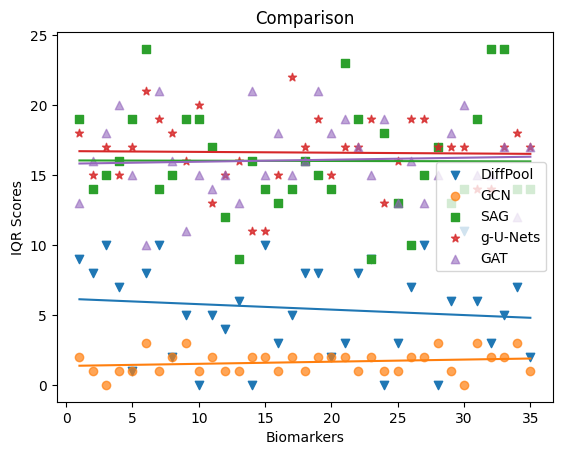

In [71]:
biomarker_list = np.array(list(range(1, len(iqc_gcn)+1)))

def FitLine(iqc_list, label):
    b, a = np.polyfit(biomarker_list, iqc_list, deg=1)
    print(a)
    plt.plot(biomarker_list, a + b * biomarker_list) # , label=label

plt.scatter(biomarker_list, iqc_diffpool, label = "DiffPool", marker ="v", alpha=1)
plt.scatter(biomarker_list, iqc_gcn, label = "GCN", alpha=0.7)
plt.scatter(biomarker_list, iqc_sag, label = "SAG", marker ="s", alpha=1)
plt.scatter(biomarker_list, iqc_gunet, label = "g-U-Nets", marker ="*", alpha=0.8)
plt.scatter(biomarker_list, iqc_gat, label = "GAT", marker ="^", alpha=0.6)


FitLine(iqc_diffpool, "diffpool")
FitLine(iqc_gcn, "gcn")
FitLine(iqc_sag, "sag")
FitLine(iqc_gunet, "gunet")
FitLine(iqc_gat, "gat")

plt.xlabel('Biomarkers')
plt.ylabel('IQR Scores')
plt.title('Comparison')
plt.legend()
#plt.show()
plt.savefig('iqr.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


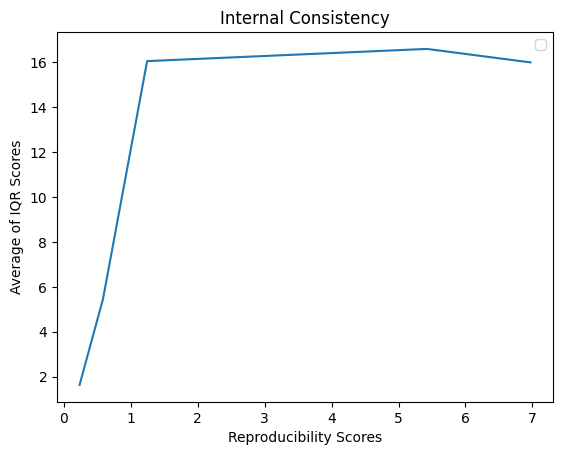

In [72]:
our_method_scores = np.array([gcn_repr_score, diffpool_repr_score, gunet_repr_score, gat_repr_score, sag_repr_score])
avg_iqr_scores = np.array([np.average(iqc_gcn), np.average(iqc_diffpool), np.average(iqc_gunet), np.average(iqc_gat), np.average(iqc_sag)])

sorted_indices = np.argsort(our_method_scores)
our_method_scores = our_method_scores[sorted_indices] # kucukten buyuge siraliyoruz linear bir dogru gozuksun diye
avg_iqr_scores = avg_iqr_scores[sorted_indices] # modellerin ayni siralamasini buraya da tasimak zorundayiz. aksi halde map olmaz pairler

plt.xlabel('Reproducibility Scores')
plt.ylabel('Average of IQR Scores')
plt.title('Internal Consistency')
plt.legend()

plt.plot(our_method_scores, avg_iqr_scores) 
plt.savefig('int_cons.png')

In [73]:
def GetAssignedBiomarkerScores(df_datasets):
    all_datasets = np.asarray(list(df_datasets[0]['n'].map(lambda x: x).to_numpy())).T
    for i, df_dataset in enumerate(df_datasets):
        if i > 0:
            all_datasets = np.concatenate((all_datasets, np.asarray(list(df_dataset['n'].map(lambda x: x).to_numpy())).T), axis=1)

    bios_scores = np.array([LA.norm(nth_bios) for nth_bios in all_datasets])
    return bios_scores

In [74]:
def PlotBiomarkerImportanceComparison(bio_scores, y_title):
    print(y_title)
    
    stdev = np.std(bio_scores)
    mean = np.average(bio_scores)    
    print(f"mean:{mean:.2f}, stdev:{stdev:.2f}")
    
    important_indices = np.where((bio_scores > mean + stdev))
    unimportant_indices = np.where((bio_scores <= mean + stdev))

    important_bios = (bio_scores > mean + stdev).astype(float)
    unimportant_bios = (bio_scores <= mean + stdev).astype(float)

    important_bios[important_indices] = bio_scores[important_indices]
    unimportant_bios[unimportant_indices] = bio_scores[unimportant_indices]

    fig, ax = plt.subplots()
    ax.stem(np.array(list(range(35)))+1, important_bios, 'g') 
    ax.stem(np.array(list(range(35)))+1, unimportant_bios, 'r')
    plt.xlabel('Biomarkers')
    plt.ylabel(y_title)
    plt.title('Biomarker Importance Comparison')
    plt.show()    

[4.603862   3.9179237  4.2638907  1.7186604  1.7869787  0.58513576
 1.4034675  1.7619854  0.62092495 3.193383   3.7032678  4.5760665
 1.2898357  0.736661   3.067084   2.5329714  1.0357927  1.9052196
 1.9327415  1.8616227  3.6942778  2.5746174  3.7360358  0.8413342
 4.56118    0.91135037 0.565278   0.77207905 3.0232272  2.5456328
 3.1191065  1.0600488  0.47222242 0.61723757 3.0426044 ]
L2 Score of Biomarkers
mean:2.23, stdev:1.32


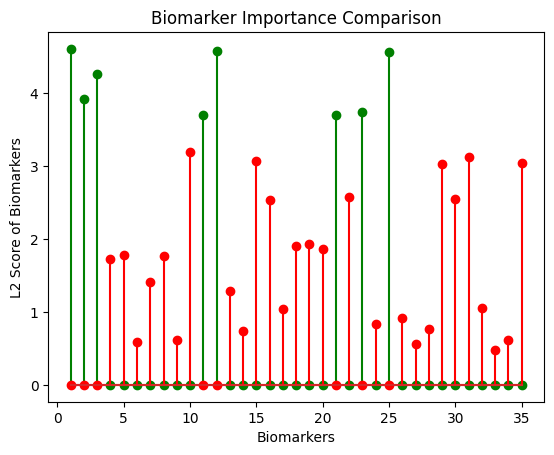

In [75]:
l2_scores = GetAssignedBiomarkerScores(gcn_datasets)
print(l2_scores)
PlotBiomarkerImportanceComparison(l2_scores, 'L2 Score of Biomarkers')

In [76]:
def GetAllDatasetsColumn(df_datasets, column_name):
    all_datasets = np.asarray(list(df_datasets[0][column_name].map(lambda x: x).to_numpy())).T
    for i, df_dataset in enumerate(df_datasets):
        if i > 0:
            all_datasets = np.concatenate((all_datasets, np.asarray(list(df_dataset[column_name].map(lambda x: x).to_numpy())).T), axis=1)
    return all_datasets

In [77]:
w_values = GetAllDatasetsColumn(gcn_datasets, 'w')
w_values_avr = np.average(w_values, axis=1)
w_values_avr

array([0.16090967, 0.1368943 , 0.1488853 , 0.06006382, 0.06166879,
       0.01890076, 0.04828353, 0.06138883, 0.02015654, 0.11157092,
       0.12941793, 0.15981285, 0.04517274, 0.02450461, 0.10713183,
       0.08741034, 0.03528562, 0.06631208, 0.06619897, 0.06498836,
       0.12883404, 0.08994766, 0.13066718, 0.0294139 , 0.15922724,
       0.03112722, 0.01948522, 0.02596077, 0.10517212, 0.08887105,
       0.10877221, 0.03690085, 0.01587145, 0.02143489, 0.10634245],
      dtype=float32)

Mean of Weights (Their Abs Taken)
mean:0.08, stdev:0.05


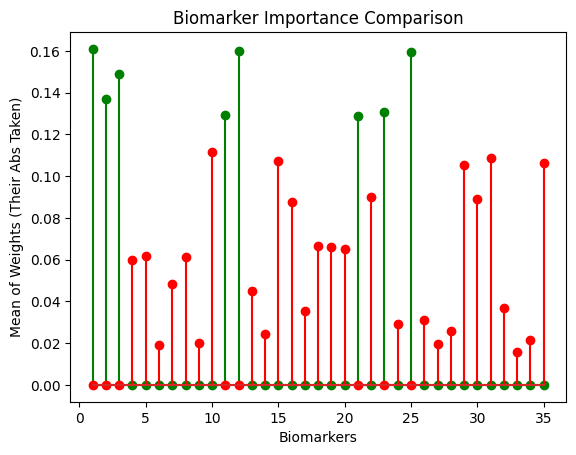

In [78]:
PlotBiomarkerImportanceComparison(w_values_avr, 'Mean of Weights (Their Abs Taken)')

In [79]:
labels = [
        "Bank of the Superior Temporal Sulcus",#1
        "Caudal Anterior-cingulate Cortex",#2
        "Caudal Middle Frontal Gyrus",#3
        "Unmeasured Corpus Callosum",#4
        "Cunesus Cortex",#5
        "Entorhinal Cortex",#6
        "Fusiform Gyrus",#7
        "Inferior Parietal Cortex",#8
        "Inferior Temporal Gyrus",#9
        "Isthmus-cingulate Cortex",#10
        "Lateral occipital cortex",#11
        "Lateral orbital frontal cortex",#12
        "Lingual gyrus",#13
        "Medial orbital frontal cortex",#14
        "Middle temporal gyrus",#15
        "Parahippocampal gyrus",#16
        "Paracentral lobule",#17
        "Pars opercularis",#18
        "Pars orbitalis",#19
        "Pars triangularis",#20
        "Pericalcarine cortex",#21
        "Postcentral gyrus",#22
        "Posterior-cingulate cortex",#23
        "Precentral gyrus",#24
        "Precuneus cortex",#25
        "Rostral anterior cingulate cortex",#26
        "Rostral middle frontal gyrus",#£7
        "Superior frontal gyrus",#28
        "Superior parietal cortex",#29
        "Superior temporal gyrus",#30
        "Supramarginal gyrus",#31
        "Frontal pole",#32
        "Temporal pole",#33
        "Transverse temporal cortex",#34
        "Insula cortex"#35
]

np.array(labels)[list(reversed((np.argsort(l2_scores))[-10:].tolist()))]

array(['Bank of the Superior Temporal Sulcus',
       'Lateral orbital frontal cortex', 'Precuneus cortex',
       'Caudal Middle Frontal Gyrus', 'Caudal Anterior-cingulate Cortex',
       'Posterior-cingulate cortex', 'Lateral occipital cortex',
       'Pericalcarine cortex', 'Isthmus-cingulate Cortex',
       'Supramarginal gyrus'], dtype='<U36')

In [80]:
from sklearn.metrics import cohen_kappa_score

In [81]:
model_name = 'diffpool'
cv = 0

In [82]:
def calculate_kappa_score_for_cv(kappa_matrix, kappa_files, master_no):
    kappa_scores = []

    with open(f"{model_name}/kappa/{kappa_files[master_no]}",'rb') as f:
        master_preds = pickle.load(f)['preds']    
        
    for k in range(len(kappa_files)):
        with open(f"{model_name}/kappa/{kappa_files[k]}",'rb') as f:
            k_preds = pickle.load(f)['preds']   
        
        print(master_preds)
        print(k_preds)
        print()
        
        kappa_matrix[master_no, k] = cohen_kappa_score(k_preds, master_preds)

    print('*******************************')

def group_by_test_view(kappa_files):
    kappa_test_view_0_files = []
    kappa_test_view_1_files = []
    kappa_test_view_2_files = []
    kappa_test_view_3_files = []
    kappa_test_view_4_files = []
    kappa_test_view_5_files = []
    
    for k_file in kappa_files:
        if 'test_with_view_0' in k_file:
            kappa_test_view_0_files.append(k_file)
        if 'test_with_view_1' in k_file:
            kappa_test_view_1_files.append(k_file)
        if 'test_with_view_2' in k_file:
            kappa_test_view_2_files.append(k_file)
        if 'test_with_view_3' in k_file:
            kappa_test_view_3_files.append(k_file)
        if 'test_with_view_4' in k_file:
            kappa_test_view_4_files.append(k_file)
        if 'test_with_view_5' in k_file:
            kappa_test_view_5_files.append(k_file)
            
    return [kappa_test_view_0_files, kappa_test_view_1_files, kappa_test_view_2_files, kappa_test_view_3_files, kappa_test_view_4_files, kappa_test_view_5_files]

In [83]:
kappa_files = os.listdir(f"{model_name}/kappa")
kappa_cv_0_files = []
kappa_cv_1_files = []
kappa_cv_2_files = []
kappa_cv_3_files = []
kappa_cv_4_files = []

for k_file in kappa_files:
    if 'CV_0' in k_file:
        kappa_cv_0_files.append(k_file)
    if 'CV_1' in k_file:
        kappa_cv_1_files.append(k_file)
    if 'CV_2' in k_file:
        kappa_cv_2_files.append(k_file)
    if 'CV_3' in k_file:
        kappa_cv_3_files.append(k_file)
    if 'CV_4' in k_file:
        kappa_cv_4_files.append(k_file)
        
kappa_cv_0_files = sorted(kappa_cv_0_files)
kappa_cv_1_files = sorted(kappa_cv_1_files)
kappa_cv_2_files = sorted(kappa_cv_2_files)
kappa_cv_3_files = sorted(kappa_cv_3_files)
kappa_cv_4_files = sorted(kappa_cv_4_files)

group_files_cv_0 = group_by_test_view(kappa_cv_0_files)
group_files_cv_1 = group_by_test_view(kappa_cv_1_files)
group_files_cv_2 = group_by_test_view(kappa_cv_2_files)
group_files_cv_3 = group_by_test_view(kappa_cv_3_files)
group_files_cv_4 = group_by_test_view(kappa_cv_4_files)

group_files = None

if cv == 0:
    group_files = group_files_cv_0
if cv == 1:
    group_files = group_files_cv_1
if cv == 2:
    group_files = group_files_cv_2
if cv == 3:
    group_files = group_files_cv_3
if cv == 4:
    group_files = group_files_cv_4

group_files

FileNotFoundError: [Errno 2] No such file or directory: 'diffpool/kappa'

In [ ]:
kappa_matrix = np.zeros((len(group_files[0]), len(group_files[0])))
                        
for i, g_files in enumerate(group_files):
    calculate_kappa_score_for_cv(kappa_matrix, g_files, i)
    
kappa_matrix

In [ ]:
kappa_matrix_flatten = kappa_matrix.flatten()
nan_and_1_indices = ~(np.isnan(kappa_matrix_flatten) | (kappa_matrix_flatten == 1))
kappa_matrix_flatten[nan_and_1_indices]

In [ ]:
np.average(kappa_matrix_flatten[nan_and_1_indices])